In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix, log_loss, accuracy_score
import re
import string
import gensim
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import csr_matrix
import tldextract
from urllib.parse import urlparse


In [3]:
pip install tldextract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
df = pd.read_csv('phishing_site_urls.csv')
df.columns = [x.lower() for x in df.columns]
df['Y'] = df['label'].apply(lambda x: 0 if x == 'good' else 1)

In [3]:
def feature_creation(x):
    features = {}
    
    dom_ngram = {}
    subdom_ngram = {}

    dom = tldextract.extract(x).domain
    subdom = tldextract.extract(x).subdomain
    n  = 2
    for index in range(0, len(dom), n):
        dom_ngram[dom[index : index + n]] = 1
    features.update(dom_ngram)

    elements = [
    {"item": "domain", "data": tldextract.extract(x).domain},
    {"item": "subdomain", "data": tldextract.extract(x).subdomain},
    {"item": "suffix", "data": tldextract.extract(x).suffix},
    {"item": "path", "data": urlparse(x).path},
    {"item": "params", "data": urlparse(x).params},
    {"item": "query", "data": urlparse(x).query},
    {"item": "fragment", "data": urlparse(x).fragment}]
    
    for i in elements:
        features[f'len_{i["item"]}'] = len(i["data"])
        for sc in '!@#$%-_=~?+;':
            features[f'len_{sc}_in_{i["item"]}'] = i["data"].count(sc)
        if i["item"] in ['domain','path','subdomain']:
            features[f'len_digits_in_{i["item"]}'] = len(re.findall('[0-9]',x))
            features[f'len_alphas_in_{i["item"]}'] = len(re.findall('[a-z]',x.lower()))
    return features

In [4]:
y_elements = []
X_elements = []

for url, label in zip(df['url'], df['Y']):
    f = feature_creation(url)
    y_elements.append(label)
    X_elements.append(f)

In [5]:
len_domain = []
for i in X_elements:
    len_domain.append(i.get('len_domain'))
    
len_digits_in_domain =[]
for i in X_elements:
    len_digits_in_domain.append(i.get('len_digits_in_domain'))

len_alphas_in_path = []
for i in X_elements:
    len_alphas_in_path.append(i.get('len_alphas_in_path'))

len_digits_in_subdomain = []
for i in X_elements:
    len_digits_in_subdomain.append(i.get('len_digits_in_subdomain'))

len_alphas_in_subdomain =[]   
for i in X_elements:
    len_alphas_in_subdomain.append(i.get('len_alphas_in_subdomain'))

len_path = []
for i in X_elements:
    len_path.append(i.get('len_path'))
    
len_digits_in_path = []
for i in X_elements:
    len_digits_in_path.append(i.get('len_digits_in_path'))

len_alphas_in_path = []
for i in X_elements:
    len_alphas_in_path.append(i.get('len_alphas_in_path'))

len_suffix = []

In [6]:
pre_processor = DictVectorizer()
X = pre_processor.fit_transform(X_elements)
X = csr_matrix(X)
X = X.tocsr()
y = np.array(y_elements).astype(int)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from sklearn.naive_bayes import MultinomialNB 
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [9]:
score = log_loss(y_test, mnb.predict_proba(X_test))
y_pred = mnb.predict(X_test)
score_acc = accuracy_score(y_test, y_pred)

print(f"Log loss: {score}")
print(f"Score acc: {score_acc}")

Log loss: 4.751005990696878
Score acc: 0.7114954036588695



CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.86      0.77      0.81     87954
           1       0.34      0.49      0.40     21916

    accuracy                           0.71    109870
   macro avg       0.60      0.63      0.61    109870
weighted avg       0.75      0.71      0.73    109870


CONFUSION MATRIX


<AxesSubplot:>

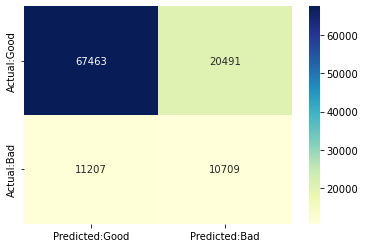

In [11]:
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(X_test), y_test),
            columns = ['Predicted:Good', 'Predicted:Bad'],
            index = ['Actual:Good', 'Actual:Bad'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(X_test), y_test))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")